In [ ]:
# Install the required packages
!pip install -r requirements.txt

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

/Users/manish/Documents/Masters/ANN/Assignment/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the data
data_dir = 'food101/images/'
data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 101000 files belonging to 101 classes.


In [4]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2
)

In [5]:
#
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [6]:
# Create a train and validation generator
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [7]:
# List of classes
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 101 ....


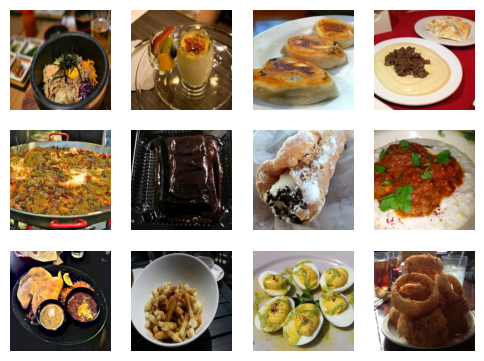

In [75]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(6,6))
    for images, labels in data.take(1):
        for i in range(12):
            ax = plt.subplot(4, 4, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

In [9]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape,
    pooling='avg'
)

for layer in pre_trained.layers:
    layer.trainable = False

In [10]:
# Adding layers to the pre-trained model
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 228, 228, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 113, 113, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 113, 113, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 113, 113, 32)         0         ['batch_normalization[0][0

In [52]:
# Train the model
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 10,
                    verbose = 1)


Epoch 1/10
2525/2525 [==============================] - 1259s 499ms/step - loss: 2.4006 - accuracy: 0.4163 - val_loss: 2.2786 - val_accuracy: 0.4492
Epoch 2/10
2525/2525 [==============================] - 1258s 498ms/step - loss: 2.3377 - accuracy: 0.4301 - val_loss: 2.2317 - val_accuracy: 0.4509
Epoch 3/10
2525/2525 [==============================] - 1263s 500ms/step - loss: 2.2660 - accuracy: 0.4416 - val_loss: 2.1860 - val_accuracy: 0.4641
Epoch 4/10
2525/2525 [==============================] - 1275s 505ms/step - loss: 2.2239 - accuracy: 0.4510 - val_loss: 2.1465 - val_accuracy: 0.4760
Epoch 5/10
2525/2525 [==============================] - 1382s 547ms/step - loss: 2.1809 - accuracy: 0.4608 - val_loss: 2.1296 - val_accuracy: 0.4835
Epoch 6/10
2525/2525 [==============================] - 1250s 495ms/step - loss: 2.1350 - accuracy: 0.4680 - val_loss: 2.1004 - val_accuracy: 0.4838
Epoch 7/10
2525/2525 [==============================] - 1339s 530ms/step - loss: 2.0956 - accuracy: 0.4766

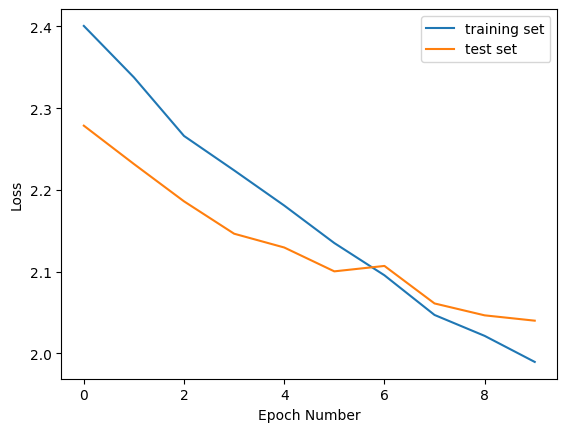

In [54]:
# Loss Plot
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

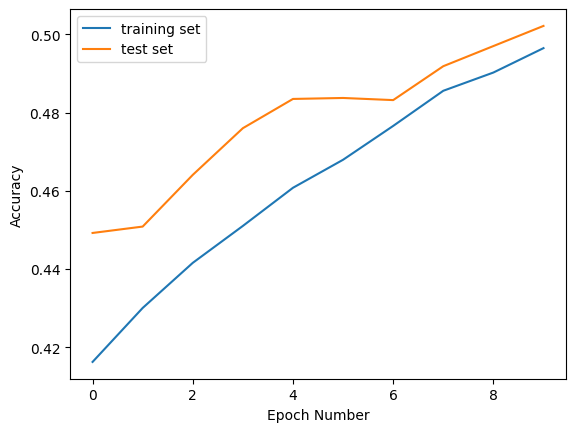

In [55]:
# Accuracy Plot
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [56]:
# Save the model
model_name = 'food_recognition_inceptionV3.keras'
model.save(model_name, save_format='keras')

In [57]:
# list of classes
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [82]:
# Function to predict the image
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Object Detected As - {}".format(str(classes[index]).title()), size=8, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 24ms/step


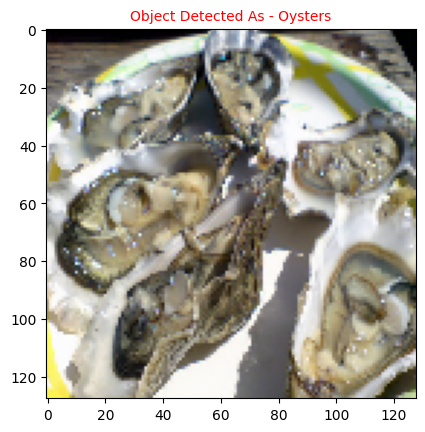

In [81]:
# Predict the image
predict_image('food101/images/oysters/6457.jpg', model)

1/1 [==============================] - 0s 49ms/step


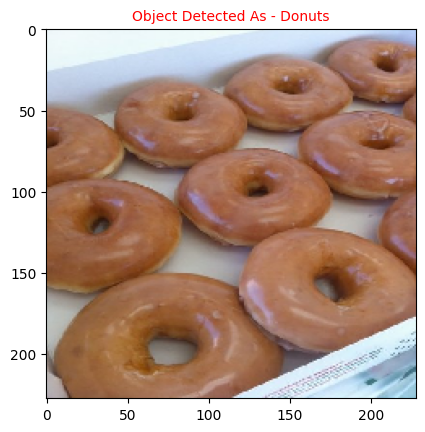

In [60]:
predict_image('food101/images/donuts/104498.jpg', model)

1/1 [==============================] - 0s 50ms/step


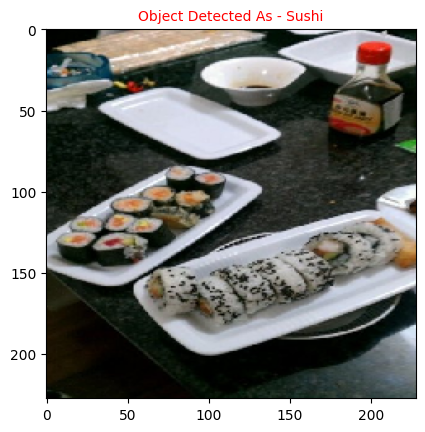

In [62]:
predict_image('food101/images/sushi/716348.jpg', model)

1/1 [==============================] - 0s 43ms/step


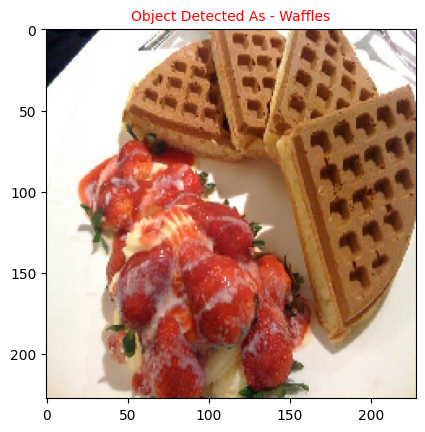

In [63]:
predict_image('food101/images/waffles/29126.jpg', model)

1/1 [==============================] - 0s 45ms/step


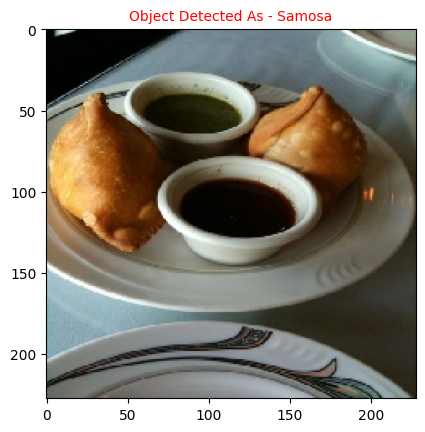

In [64]:
predict_image('food101/images/samosa/1976.jpg', model)

1/1 [==============================] - 0s 73ms/step


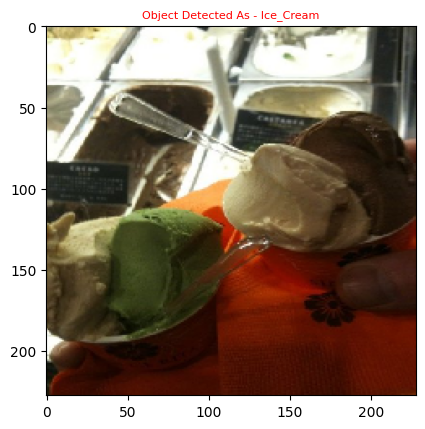

In [85]:
predict_image('food101/images/ice_cream/19487.jpg', model)

1/1 [==============================] - 0s 39ms/step


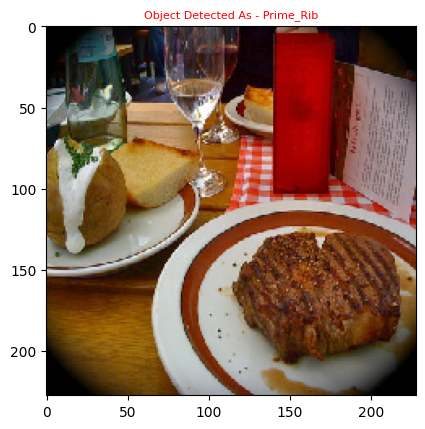

In [86]:
# Incorrect Prediction
predict_image('food101/images/steak/3136.jpg', model)

1/1 [==============================] - 0s 42ms/step


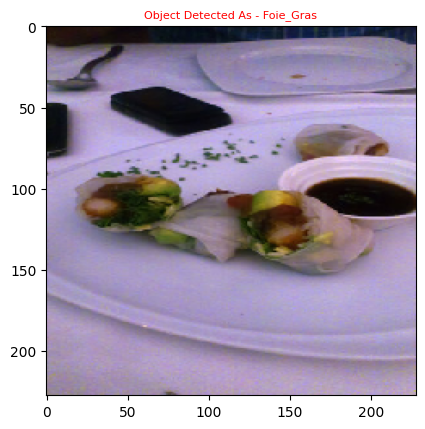

In [90]:
# Incorrect Prediction
predict_image('food101/images/spring_rolls/1480137.jpg', model)